In [34]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import wrf
from wrf_parallel import get_storm_motion, get_mean_var_hgt
from era5_read import read_era5
import datetime as dt
import metpy.units as units
import metpy.calc as mpcalc
import glob

#lon1 = 147; lat1 = -38; lon2 = 155; lat2 = -28              #Max
lon1 = 150.50; lat1 = -34.49; lon2 = 151.60; lat2 = -33.49   #X-large
#lon1 = 150.5; lat1 = -34.5; lon2 = 151.6; lat2 = -33.5      #Large
#lon1 = 151; lat1 = -34.2; lon2 = 151.6; lat2 = -33.6        #Med
#lon1 = 151.1; lat1 = -34.2; lon2 = 151.5; lat2 = -33.9      #Small
m = Basemap(llcrnrlon=lon1, llcrnrlat=lat1, urcrnrlon=lon2, urcrnrlat=lat2,projection="cyl",resolution="h")
times = ["2015-12-15 23:00","2015-12-16 00:00","2015-12-16 01:00","2015-12-16 02:00"]


In [35]:
def load_barra_sy(times):
    barra_sy_path = "/g/data/ma05/BARRA_SY/v1/forecast/"
    barra_sy_u_files = []; barra_sy_v_files = []; barra_sy_w_files = []; barra_sy_z_files = []; barra_sy_rh_files = []; barra_sy_ta_files = []; barra_sy_wg_files = []; 
    for t in times:
        date = dt.datetime.strptime(t, "%Y-%m-%d %H:%M")
        barra_sy_u_files.append(glob.glob(barra_sy_path + "prs/wnd_ucmp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/wnd_ucmp-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_v_files.append(glob.glob(barra_sy_path + "prs/wnd_vcmp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/wnd_vcmp-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_w_files.append(glob.glob(barra_sy_path + "prs/vertical_wnd/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/vertical_wnd-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_z_files.append(glob.glob(barra_sy_path + "prs/geop_ht/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/geop_ht-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_rh_files.append(glob.glob(barra_sy_path + "prs/relhum/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/relhum-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_ta_files.append(glob.glob(barra_sy_path + "prs/air_temp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/air_temp-fc-prs-PT1H-BARRA_SY-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_wg_files.append(glob.glob(barra_sy_path + "spec/max_wndgust10m/"+date.strftime("%Y")+\
                                           "/"+date.strftime("%m")+"/max_wndgust10m-fc-spec-PT1H-BARRA_SY-v1-"+\
                                           date.strftime("%Y%m%d*")+".sub.nc"))

    barra_sy_u = xr.open_mfdataset(np.unique(barra_sy_u_files), concat_dim="time", combine="by_coords").\
        sel({"time":slice(times[0], times[-1])})
    barra_sy_v = xr.open_mfdataset(np.unique(barra_sy_v_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1])})
    barra_sy_w = xr.open_mfdataset(np.unique(barra_sy_w_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_z = xr.open_mfdataset(np.unique(barra_sy_z_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_rh = xr.open_mfdataset(np.unique(barra_sy_rh_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_ta = xr.open_mfdataset(np.unique(barra_sy_ta_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_wg = xr.open_mfdataset(np.unique(barra_sy_wg_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_u = barra_sy_u.interp({"latitude":barra_sy_z.latitude, "longitude":barra_sy_z.longitude})
    barra_sy_v = barra_sy_v.interp({"latitude":barra_sy_z.latitude, "longitude":barra_sy_z.longitude})
    barra_sy_topog = xr.open_dataset("/g/data/ma05/BARRA_SY/v1/static/topog-fc-slv-PT0H-BARRA_SY-v1.nc").interp_like(barra_sy_z)["topog"]
    
    return [barra_sy_u, barra_sy_v, barra_sy_w, barra_sy_z, barra_sy_rh, barra_sy_ta, barra_sy_wg, barra_sy_topog]
    
def load_barra_r(times):
    barra_sy_path = "/g/data/ma05/BARRA_R/v1/forecast/"
    barra_sy_u_files = []; barra_sy_v_files = []; barra_sy_w_files = []; barra_sy_z_files = []; barra_sy_rh_files = []; barra_sy_ta_files = []; barra_sy_wg_files = []; barra_sy_scp_files = []; 
    for t in times:
        date = dt.datetime.strptime(t, "%Y-%m-%d %H:%M")
        barra_sy_u_files.append(glob.glob(barra_sy_path + "prs/wnd_ucmp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/wnd_ucmp-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_v_files.append(glob.glob(barra_sy_path + "prs/wnd_vcmp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/wnd_vcmp-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_w_files.append(glob.glob(barra_sy_path + "prs/vertical_wnd/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/vertical_wnd-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_z_files.append(glob.glob(barra_sy_path + "prs/geop_ht/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/geop_ht-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_rh_files.append(glob.glob(barra_sy_path + "prs/relhum/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/relhum-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_ta_files.append(glob.glob(barra_sy_path + "prs/air_temp/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/air_temp-fc-prs-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_wg_files.append(glob.glob(barra_sy_path + "spec/max_wndgust10m/"+date.strftime("%Y")+"/"+date.strftime("%m")+"/max_wndgust10m-fc-spec-PT1H-BARRA_R-v1-"+date.strftime("%Y%m%d*")+".sub.nc"))
        barra_sy_scp_files.append(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/barra_fc/barra_fc_"+date.strftime("%Y%m"+"*.nc")))

    barra_sy_u = xr.open_mfdataset(np.unique(barra_sy_u_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1])})
    barra_sy_v = xr.open_mfdataset(np.unique(barra_sy_v_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1])})
    barra_sy_w = xr.open_mfdataset(np.unique(barra_sy_w_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_z = xr.open_mfdataset(np.unique(barra_sy_z_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_rh = xr.open_mfdataset(np.unique(barra_sy_rh_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_ta = xr.open_mfdataset(np.unique(barra_sy_ta_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_wg = xr.open_mfdataset(np.unique(barra_sy_wg_files), concat_dim="time", combine="by_coords").sel({"time":slice(times[0], times[-1]), "latitude":slice(lat1-0.01, lat2+0.01), "longitude":slice(lon1-0.01, lon2+0.01)})
    barra_sy_u = barra_sy_u.interp({"latitude":barra_sy_z.latitude, "longitude":barra_sy_z.longitude})
    barra_sy_v = barra_sy_v.interp({"latitude":barra_sy_z.latitude, "longitude":barra_sy_z.longitude})
    barra_sy_topog = xr.open_dataset("/g/data/ma05/BARRA_R/v1/static/topog-an-slv-PT0H-BARRA_R-v1.nc").interp_like(barra_sy_z)["topog"]
    barra_sy_scp = xr.open_mfdataset(np.unique(barra_sy_scp_files), combine="nested", concat_dim="time")["scp"].sel({"time":slice(times[0], times[-1])}).interp({"lat":barra_sy_z.latitude, "lon":barra_sy_z.longitude})
                                  
    return [barra_sy_u, barra_sy_v, barra_sy_w, barra_sy_z, barra_sy_rh, barra_sy_ta, barra_sy_wg, barra_sy_topog, barra_sy_scp]
                                  
barra_sy_u, barra_sy_v, barra_sy_w, barra_sy_z, barra_sy_rh, barra_sy_ta, barra_sy_wg, barra_sy_topog = load_barra_sy(times)
barra_r_u, barra_r_v, barra_r_w, barra_r_z, barra_r_rh, barra_r_ta, barra_r_wg, barra_r_topog, barra_r_scp = load_barra_r(times)

In [36]:
def get_srh(u,v,hgt,hgt_bot,hgt_top,terrain):
    #Get storm relative helicity [lat, lon] based on 3d input of u, v, and storm motion u and
    # v components
    # Is between the bottom pressure level (1000 hPa), approximating 0 m, and hgt_top (m)
    #Storm motion approxmiated by using mean 0-6 km wind

    u_storm_right, v_storm_right, u_storm_left, v_storm_left = \
        get_storm_motion(np.copy(u), np.copy(v), np.copy(hgt), terrain)
    
    #For the Kurnell wind storm, use actual storm motion...(7.5 m/s at 19 deg)
    u_storm_left = 7.5*np.sin(np.deg2rad(19))
    v_storm_left = 7.5*np.cos(np.deg2rad(19))
    
    hgt = hgt - terrain
    u_ma = np.ma.masked_where((hgt < hgt_bot) | (hgt > hgt_top) | \
            (np.isnan(hgt_bot)) | (np.isnan(hgt_top)) | (np.isnan(hgt)), u)
    v_ma = np.ma.masked_where((hgt < hgt_bot) | (hgt > hgt_top) | \
            (np.isnan(hgt_bot)) | (np.isnan(hgt_top)) | (np.isnan(hgt)) , v)
    sru_left = u_ma - u_storm_left
    srv_left = v_ma - v_storm_left
    layers_left = (sru_left[1:] * srv_left[:-1]) - (sru_left[:-1] * srv_left[1:])
    srh_left = (np.sum(layers_left,axis=0))
    sru_right = u_ma - u_storm_right
    srv_right = v_ma - v_storm_right
    layers_right = (sru_right[1:] * srv_right[:-1]) - (sru_right[:-1] * srv_right[1:])
    srh_right = (np.sum(layers_right,axis=0))

    return srh_left, srh_right

def get_uh(w, p3d, ta, q_unit, u, v, dx, dy, hgt, terrain, hgt_bot=2000, hgt_top=5000):

    #From Kain et al (2008)

    vo3d = np.zeros(u.shape)
    for i in np.arange(vo3d.shape[0]):
        vo3d[i] = mpcalc.vorticity(u[i], v[i], dx, dy)
    levs = np.arange(hgt_bot, hgt_top+1000, 1000)
    w_comp = np.zeros( (len(levs)-1, w.shape[1], w.shape[2]) ) 
    vo_comp = np.zeros( (len(levs)-1, w.shape[1], w.shape[2]) ) 
    for l in np.arange(len(levs) - 1):
        #vo_comp[l] = get_mean_var_hgt(vo3d, hgt, levs[l], levs[l+1], terrain, True, p3d)
        #w_comp[l] = get_mean_var_hgt(w, hgt, levs[l], levs[l+1], terrain, True, p3d)
        vo_comp[l] = get_mean_var_hgt(vo3d, hgt, levs[l], levs[l+1], terrain)
        w_comp[l] = get_mean_var_hgt(w, hgt, levs[l], levs[l+1], terrain)
    uh = np.sum((vo_comp * w_comp), axis=0) * 1000  
    return uh

def plot(u_ds, v_ds, w_ds, z_ds, wg_ds, rh_ds, ta_ds, topog, times, stride=1, hgt=1500, contour="scp", scp=None):

    x,y = np.meshgrid(u_ds.longitude.values, u_ds.latitude.values)
    plt.figure(figsize=[18,8])
    for t in np.arange(len(times)):
        z = z_ds["geop_ht"].isel({"time":t}).values
        z = np.where(z==hgt, z+1e-3, z)
        u = u_ds["wnd_ucmp"].isel({"time":t}).values
        v = v_ds["wnd_vcmp"].isel({"time":t}).values
        w = w_ds["vertical_wnd"].isel({"time":t}).values
        ta = ta_ds["air_temp"].isel({"time":t}).values
        rh = rh_ds["relhum"].isel({"time":t}).values
        
        left, right = get_srh(np.flip(u),np.flip(v),np.flip(z),0,1000,topog.values)
        
        p = u_ds["pressure"].values
        p_3d = np.moveaxis(np.tile(p,[z.shape[1],z.shape[2],1]),[0,1,2],[1,2,0])
        p_unit = units.units.hectopascals*p_3d
        q_unit = mpcalc.mixing_ratio_from_relative_humidity(rh/100,\
            ta*units.units["K"],p_unit)
        x, y = np.meshgrid(ta_ds.longitude.values,ta_ds.latitude.values)
        dx, dy = mpcalc.lat_lon_grid_deltas(x,y)
        uh = get_uh(w, p_3d, ta, q_unit, u, v, dx, dy, z, topog.values)
        
        
        u = wrf.interpz3d(u, z, np.array(hgt))
        v = wrf.interpz3d(v, z, np.array(hgt))
        w = wrf.interpz3d(w, z, np.array(hgt))
        
        u = u[0:u.shape[0]:stride, 0:u.shape[1]:stride]
        v = v[0:v.shape[0]:stride, 0:v.shape[1]:stride]
        x1 = x[0:x.shape[0]:stride, 0:x.shape[1]:stride]
        y1 = y[0:y.shape[0]:stride, 0:y.shape[1]:stride]        

        plt.subplot(len(times)/2,2,t+1)
        if contour == "srh":
            m.contourf(x, y, left, cmap=plt.get_cmap("RdBu_r"), levels=np.linspace(-250,250,10), extend="both")
            cb = plt.colorbar()
            cb.set_label("SRH $(m^{2}/s^{2})$")
        elif contour == "wg":
            m.contourf(x, y, wg_ds["max_wndgust10m"][t].values, cmap=plt.get_cmap("Reds"), levels=np.linspace(0,30,10), extend="max")
            cb = plt.colorbar()
            cb.set_label("Wind gust $(m/s)$")
        elif contour == "uhel":
            m.contourf(x, y, (uh), cmap=plt.get_cmap("RdBu_r"), levels=np.linspace(-250, 250,10), extend="both")
            cb = plt.colorbar()
            cb.set_label("UHel $(m^{2}/s^{2})$")
        elif contour == "scp":
            m.contourf(x, y, scp[t].values, cmap=plt.get_cmap("Reds"), levels=np.linspace(0,2.5,10), extend="max")       
            cb = plt.colorbar();
            cb.set_label("SCP")
            
        m.quiver(x1, y1, u, v)
        m.contour(x, y, w, levels=[1,2,5,10])
        m.drawcoastlines()
        plt.title(times[t])
        m.plot([151.2069] , [-34.0116], linestyle="none", marker="o", color="tab:blue")
        m.plot([150.8931] , [-34.4278], linestyle="none", marker="o", color="tab:blue")
        m.plot([151.2093] , [-33.8688], linestyle="none", marker="o", color="tab:blue")

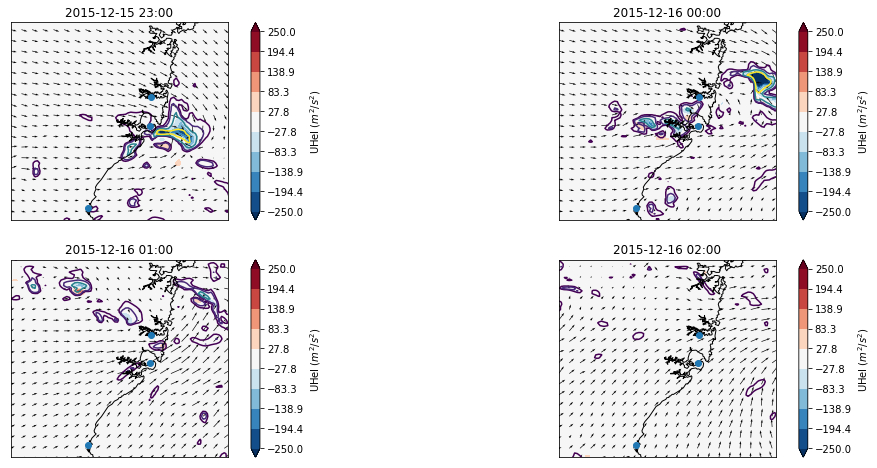

In [38]:
plot(barra_sy_u, barra_sy_v, barra_sy_w, barra_sy_z, barra_sy_wg, barra_sy_rh, barra_sy_ta, barra_sy_topog, times, stride=4, hgt=2500, contour="uhel")
plt.savefig("/g/data/eg3/ab4502/figs/barra_sy_kurnell_wg.png", bbox_inches="tight")

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: No contour levels were found within the data range.
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: No contour levels were found within the data range.
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: No contour levels were found within the data range.
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: No contour levels were found within the data range.


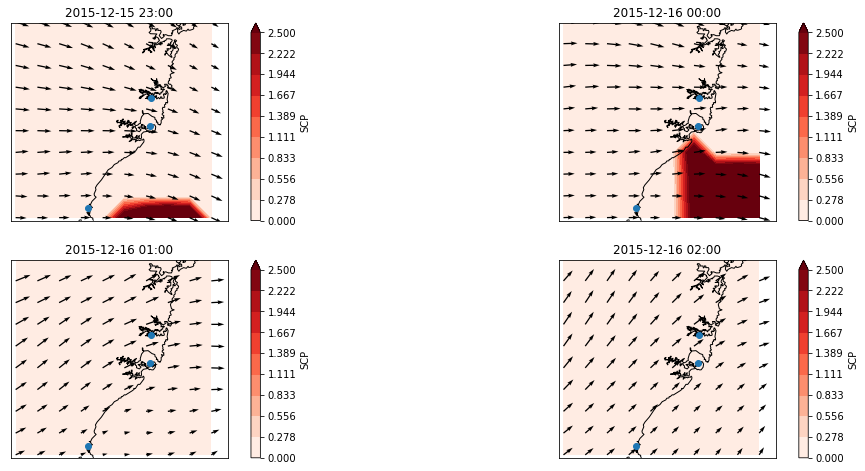

In [39]:
plot(barra_r_u, barra_r_v, barra_r_w, barra_r_z, barra_r_wg, barra_r_rh, barra_r_ta, barra_r_topog, times, stride=1, hgt=2500, contour="scp", scp=barra_r_scp)
plt.savefig("/g/data/eg3/ab4502/figs/barra_r_kurnell_scp.png", bbox_inches="tight")

NameError: name 'barra_sy_u_files' is not defined